In [1]:
import tkinter as tk
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import defaultdict
import rapidfuzz

In [2]:
data = pd.read_csv('A_Z Handwritten Data.csv')

In [3]:
print(data.head())

   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.639  0.640  0.641  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.642  0.643  0.644  0.645  0.646  0.647  0.648  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]


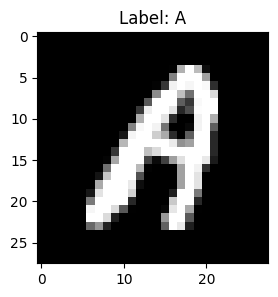

In [4]:
first_row = data.iloc[0]
label = first_row.iloc[0]
image_data = first_row.iloc[1:].values

image = image_data.reshape((28, 28))

plt.figure(figsize=(3,3))
plt.imshow(image, cmap='gray')
plt.title(f"Label: {chr(label + ord('A'))}") 
plt.show()

In [5]:
# Chuẩn bị dữ liệu
data_array = data.to_numpy()
labels = data_array[:, 0]
images = data_array[:, 1:].reshape(-1, 28, 28) / 255

# Chia dữ liệu thành tập huấn luyện, validation và test
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Xây dựng mô hình
my_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])


my_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


my_model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


my_model.save('handwritten_model.h5')

C:\Users\admin\anaconda3\envs\project\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8916 - loss: 0.3892 - val_accuracy: 0.9672 - val_loss: 0.1191
Epoch 2/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9696 - loss: 0.1024 - val_accuracy: 0.9705 - val_loss: 0.1005
Epoch 3/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9773 - loss: 0.0755 - val_accuracy: 0.9766 - val_loss: 0.0811
Epoch 4/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9817 - loss: 0.0608 - val_accuracy: 0.9784 - val_loss: 0.0785
Epoch 5/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9836 - loss: 0.0526 - val_accuracy: 0.9788 - val_loss: 0.0757
Epoch 6/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9861 - loss: 0.0451 - val_accuracy: 0.9804 - val_loss: 0.0785
Epoch 7/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.9825 - val_loss: 0.0689
Epoch 8/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9889 - loss: 0

In [6]:
def load_and_classify_dictionary(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        words = [line.strip().lower() for line in file]
    classified_dict = defaultdict(list)
    for word in words:
        if word:
            classified_dict[word[0]].append(word)
    return classified_dict

# Load từ điển (thay đường dẫn thực tế)
word_dictionary = load_and_classify_dictionary("dictionary.txt")

In [7]:
def predict_Characters(characters):
    if not characters:
        return None
    char_labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    try:
        characters_batch = np.stack(characters) / 255.0  # Chuẩn hóa dữ liệu
        model_predictions = my_model.predict(characters_batch)
        predicted_labels = np.argmax(model_predictions, axis=1)
        return [char_labels[label] for label in predicted_labels]
    except Exception as e:
        print(f"Error: {e}")
        return None

In [8]:
def preprocess_and_segment_image(image):
    # Nếu image là đường dẫn file, đọc file bằng cv2
    if isinstance(image, str):
        image = cv2.imread(image)
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Nếu image là đối tượng PIL, chuyển thành numpy array
        grayscale_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    blurred_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)
    binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 41, 25)

    num_labels, labels_im = cv2.connectedComponents(binary_image, connectivity=8)
    characters = []
    bounding_boxes = []

    for label in range(1, num_labels):
        mask = (labels_im == label).astype(np.uint8) * 255
        x, y, w, h = cv2.boundingRect(mask)
        if w < 10 or h < 10:  # Bỏ qua nhiễu
            continue
        character = binary_image[y:y+h, x:x+w]
        resized_character = cv2.resize(character, (18, 18))
        padded_character = np.pad(resized_character, ((5, 5), (5, 5)), mode='constant', constant_values=0)
        characters.append(padded_character)
        bounding_boxes.append((x, y, w, h))

    combined = list(zip(bounding_boxes, characters))
    sorted_combined = sorted(combined, key=lambda item: item[0][0])  # Sắp xếp theo vị trí x
    sorted_characters = [item[1] for item in sorted_combined]

    # Hiển thị các ký tự đã phân đoạn
    if len(sorted_characters) > 1:
        fig, axs = plt.subplots(1, len(sorted_characters), figsize=(15, 5))
    else:
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    
    if len(sorted_characters) == 1:
        axs = [axs]

    for i, char_img in enumerate(sorted_characters):
        axs[i].imshow(char_img, cmap='gray')
        axs[i].axis('off')
    plt.show()

    return sorted_characters

In [9]:
def detect_words(image):
    img_array = np.array(image.convert('L'))
    column_sums = np.sum(img_array < 128, axis=0)
    threshold = 50  # Ngưỡng khoảng trắng lớn
    words_boundaries = []
    start = 0

    for i in range(1, len(column_sums)):
        if column_sums[i] == 0 and column_sums[i-1] > 0:
            if i - start > threshold:
                words_boundaries.append((start, i))
            start = i
    if start < len(column_sums) - 1:
        words_boundaries.append((start, len(column_sums)))
    return words_boundaries

In [10]:
def detect_words(image):
    img_array = np.array(image.convert('L'))
    column_sums = np.sum(img_array < 128, axis=0)
    threshold = 50  # Ngưỡng khoảng trắng lớn
    words_boundaries = []
    start = 0

    for i in range(1, len(column_sums)):
        if column_sums[i] == 0 and column_sums[i-1] > 0:
            if i - start > threshold:
                words_boundaries.append((start, i))
            start = i
    if start < len(column_sums) - 1:
        words_boundaries.append((start, len(column_sums)))
    return words_boundaries

In [16]:
from rapidfuzz.distance import Levenshtein

def find_closest_word(predicted_text, first_char):
    if not predicted_text or first_char.lower() not in word_dictionary:
        return predicted_text
    possible_words = word_dictionary[first_char.lower()]
    min_distance = float('inf')
    closest_word = predicted_text.lower()

    for word in possible_words:
        distance = Levenshtein.distance(predicted_text.lower(), word)  # Sử dụng Levenshtein.distance
        if distance < min_distance:
            min_distance = distance
            closest_word = word
    return closest_word if min_distance <= 2 else predicted_text

In [17]:
def paint(event):
    x1, y1 = (event.x - 8), (event.y - 8)
    x2, y2 = (event.x + 8), (event.y + 8)
    canvas.create_oval(x1, y1, x2, y2, fill='black', width=2)
    draw.ellipse([x1, y1, x2, y2], fill='black')

In [18]:
def clear_canvas():
    global canvas_image, draw
    canvas.delete("all")
    canvas_image = Image.new("RGB", (800, 800), "white")
    draw = ImageDraw.Draw(canvas_image)
    result_label.config(text="Predicted: ")

In [19]:
def predict_character():
    characters = preprocess_and_segment_image(canvas_image)
    if not characters:
        result_label.config(text="Predicted: No characters detected")
        return

    # Dự đoán các ký tự
    predictions = predict_Characters(characters)
    if not predictions:
        result_label.config(text="Predicted: Error in prediction")
        return

    # Phát hiện các từ dựa trên khoảng trắng
    word_boundaries = detect_words(canvas_image)
    predicted_words = []

    # Tách các ký tự thành từ dựa trên khoảng trắng
    char_idx = 0
    for start, end in word_boundaries:
        word_chars = []
        while char_idx < len(predictions):
            x, _, _, _ = cv2.boundingRect(characters[char_idx])
            if start <= x <= end:
                word_chars.append(predictions[char_idx])
                char_idx += 1
            else:
                break
        if word_chars:
            predicted_text = ''.join(word_chars)
            corrected_word = find_closest_word(predicted_text, predicted_text[0])
            predicted_words.append(corrected_word)

    final_text = " ".join(predicted_words)
    result_label.config(text=f"Predicted: {final_text}")

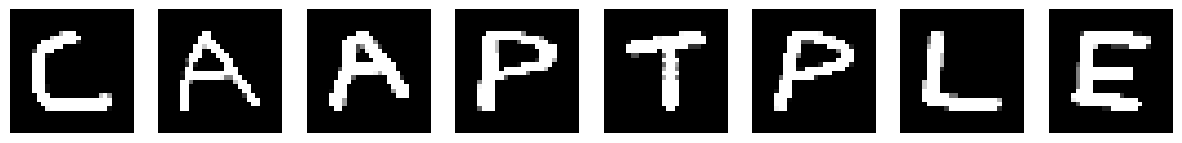

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


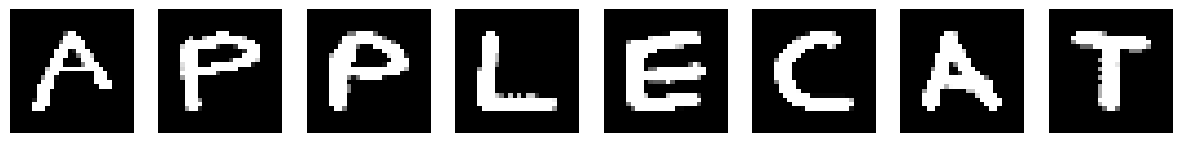

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [21]:
def setup_gui():
    global window, canvas, canvas_image, draw, result_label

    window = tk.Tk()
    window.title("Character Recognition Board")

    canvas = tk.Canvas(window, width=800, height=800, bg='white')
    canvas.pack()
    canvas.bind("<B1-Motion>", paint)

    canvas_image = Image.new("RGB", (800, 800), "white")
    draw = ImageDraw.Draw(canvas_image)

    predict_button = tk.Button(window, text="Predict", command=predict_character)
    predict_button.pack()

    clear_button = tk.Button(window, text="Clear", command=clear_canvas)
    clear_button.pack()

    result_label = tk.Label(window, text="Predicted: ", font=("Arial", 14))
    result_label.pack()

    window.mainloop()

# Chạy GUI
setup_gui()